In [1]:
import pandas as pd
import geopandas as gpd
from dask.distributed import Client
import dask.dataframe as dd
from dask_jobqueue import SLURMCluster
import os
import matplotlib.pyplot as plt
import constants
import numpy as np
from panel_utilities import get_value_variable_names
import dask_geopandas
INPUT_DATA_EVICTIONS = "../data/02_intermediate/evictions.csv"
INPUT_DATA_TRACTS = "../data/02_intermediate/tracts.csv"
INPUT_DATA_TAX_PARCELS = "../data/02_intermediate/tax_parcels.gpkg"
INPUT_DATA_ZESTIMATES = "../data/02_intermediate/zestimates.csv"
INPUT_DATA_CRIME = "../data/01_raw/crime_incidents"
INPUT_DATA_NEIGHBORHOODS = "../data/01_raw/Boston_Neighborhoods/Boston_Neighborhoods.shp"
OUTPUT_DATA_ZILLOW = "../data/03_cleaned/zestimates_analysis.csv"
OUTPUT_DATA_CRIME = "../data/03_cleaned/crime_analysis_monthly.csv"
OUTPUT_DATA_NEIGHBORHOOD_CRIME_COUNTS = "../data/03_cleaned/neighborhood_crime_counts.csv"
OUTPUT_TABLES = "../output/final_paper/tables/"
VERBOSE = True
N_PARTITIONS = 1
value_vars_to_concat = []  # A list of DataFrames, where each DataFrame contains the panel data for a single outcome variable and has case_number as its index.

/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_136917/1660558052.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/late

## 1. Loading Evictions Data

In [2]:
# Load evictions data.
with open(INPUT_DATA_EVICTIONS, 'r') as file:
    all_column_names = set(file.readline().replace("\"", "").replace("\n", "").split(","))
to_drop = {'Accuracy Score', 'Accuracy Type', 'Number', 'Street', 'Unit Type', 'Unit Number',
           'State', 'Zip', 'Country', 'Source', 'Census Year', 'State FIPS', 'County FIPS',
           'Place Name', 'Place FIPS', 'Census Tract Code', 'Census Block Code', 'Census Block Group',
           'Metro/Micro Statistical Area Code', 'Metro/Micro Statistical Area Type',
           'Combined Statistical Area Code', 'Metropolitan Division Area Code', 'court_location',
           'defendant', 'defendant_atty', 'defendant_atty_address_apt',
           'defendant_atty_address_city', 'defendant_atty_address_name', 'defendant_atty_address_state',
           'defendant_atty_address_street', 'defendant_atty_address_zip', 'docket_history', 'judgment_for',
           'judgment_total', 'plaintiff', 'plaintiff_atty', 'plaintiff_atty_address_apt',
           'plaintiff_atty_address_city', 'plaintiff_atty_address_name', 'plaintiff_atty_address_state',
           'plaintiff_atty_address_street', 'plaintiff_atty_address_zip', 'Metropolitan Division Area Name',
           'property_address_city', 'property_address_state', 'property_address_street',
           'property_address_zip'}
evictions_df = pd.read_csv(INPUT_DATA_EVICTIONS, usecols=set(all_column_names) - set(to_drop))
sample_restriction_table_index = []
sample_restriction_table_values = []

# Restrict to cases in Boston.
boston_mask = ((evictions_df['County'] == "Suffolk County") & (~evictions_df['City'].isin(["Chelsea", "Revere", "Winthrop"])))
if VERBOSE:
    print(f"Restricting to {boston_mask.sum()} observations which are from Boston.")
evictions_df = evictions_df.loc[boston_mask, :]
original_N = len(evictions_df)
if VERBOSE:
    print(f"Beginning with {original_N} observations.")
sample_restriction_table_index.append("Case Filed in Boston")
sample_restriction_table_values.append(original_N)



# Drop cases where initiating action is unknown
mask = evictions_df['initiating_action'] == "Summary Process - Residential (c239)"
if VERBOSE:
    print(f"Dropping {mask.sum()} cases for which the initiating action could not be scraped")
evictions_df = evictions_df.loc[~mask, :]
sample_restriction_table_index.append("Non-missing case initiating action")
sample_restriction_table_values.append(len(evictions_df))

# Drop cases initiated due to foreclosure
mask = evictions_df['initiating_action'].str.contains("Foreclosure")
if VERBOSE:
    print(f"Dropping {mask.sum()} cases which began due to foreclosure")
evictions_df = evictions_df.loc[~mask, :]
sample_restriction_table_index.append("Case initiated for reason other than foreclosure")
sample_restriction_table_values.append(len(evictions_df))



# Drop cases missing latest_docket_date.
mask = evictions_df['latest_docket_date'].notna()
if VERBOSE:
    print(
        f"Dropping {evictions_df['latest_docket_date'].isna().sum()} observations where latest_docket_date is missing.")
evictions_df = evictions_df.loc[mask, :]
sample_restriction_table_index.append("Non-missing latest docket date")
sample_restriction_table_values.append(len(evictions_df))

# Drop malformed addresses.
if VERBOSE:
    print(f"Dropping {evictions_df['property_address_full'].str.contains('span, span span').sum()} observations which "
          f"have malformed addresses.")
evictions_df = evictions_df.loc[~evictions_df['property_address_full'].str.contains("span, span span"), :]

# Drop missing addresses.
no_address_info_mask = (evictions_df['property_address_full'].isna())
if VERBOSE:
    print(
        f"Dropping {no_address_info_mask.sum()} rows missing property_address_full")
evictions_df = evictions_df.loc[~no_address_info_mask, :]
sample_restriction_table_index.append("Non-missing property address")
sample_restriction_table_values.append(len(evictions_df))

# Add file month and year to dataset.
evictions_df.loc[:, 'file_month'] = pd.to_datetime(evictions_df['file_date']).dt.strftime('%Y-%m')
evictions_df.loc[:, 'file_year'] = pd.to_datetime(evictions_df['file_date']).dt.year

# Add latest docket month and year to dataset.
evictions_df.loc[:, 'latest_docket_month'] = pd.to_datetime(evictions_df['latest_docket_date']).dt.strftime('%Y-%m')
evictions_df.loc[:, 'latest_docket_year'] = pd.to_datetime(evictions_df['latest_docket_date']).dt.year

"""# Drop cases concluded in April 2020 or later.
pre_pandemic_months = ['2019-04',
 '2019-05',
 '2019-06',
 '2019-07',
 '2019-08',
 '2019-09',
 '2019-10',
 '2019-11',
 '2019-12',
 '2020-01',
 '2020-02',
 '2020-03']
pre_pandemic_mask = evictions_df['latest_docket_month'].isin(pre_pandemic_months)
evictions_df = evictions_df.loc[pre_pandemic_mask, :]
if VERBOSE:
    print(f"Dropping {(~pre_pandemic_mask).sum()} cases which concluded after pandemic began")
sample_restriction_table_index.append("Case concluded before April 2020")
sample_restriction_table_values.append(len(evictions_df))"""

# Drop cases where disposition found is other.
disposition_found_other_mask = (evictions_df['disposition_found'] == "Other") | (evictions_df['disposition_found'].isna())
if VERBOSE:
    print(f"Dropping {disposition_found_other_mask.sum()} cases where disposition_found is \"Other\" or missing.")
evictions_df = evictions_df.loc[~disposition_found_other_mask, :]
sample_restriction_table_index.append("Cases for which disposition could be scraped")
sample_restriction_table_values.append(len(evictions_df))

# Drop cases resolved via mediation.
mediated_mask = evictions_df['disposition_found'] == "Mediated"
if VERBOSE:
    print(f"Dropping {mediated_mask.sum()} cases resolved through mediation.")
evictions_df = evictions_df.loc[~mediated_mask, :]
sample_restriction_table_index.append("Case not resolved through mediation")
sample_restriction_table_values.append(len(evictions_df))

# Drop rows which contain inconsistent values of disposition_found and judgment_for_pdu.
# First, we drop cases where disposition_found is "Defaulted" but judgment_for_pdu is "Defendant"
inconsistent_mask_1 = ((evictions_df['disposition_found'] == "Defaulted") & (evictions_df['judgment_for_pdu'] == "Defendant"))
if VERBOSE:
    print(f"Dropping {inconsistent_mask_1.sum()} observations where disposition_found is \"Defaulted\" but judgment_for_pdu is \"Defendant\".")
evictions_df = evictions_df.loc[~inconsistent_mask_1, :]
          
# Next, we drop cases where disposition_found is "Dismissed" yet judgment_for_pdu is "Plaintiff"
inconsistent_mask_2 = ((evictions_df['disposition_found'] == "Dismissed") & (evictions_df['judgment_for_pdu'] == "Plaintiff"))
if VERBOSE:
    print(f"Dropping {inconsistent_mask_2.sum()} observations where disposition_found is \"Dismissed\" but judgment_for_pdu is \"Plaintiff\".")
evictions_df = evictions_df.loc[~inconsistent_mask_2, :]
sample_restriction_table_index.append("Succesfully scraped judgment")
sample_restriction_table_values.append(len(evictions_df))

# Clean the values in the judgment_for_pdu variable.
judgment_for_pdu_replacement_dict = {"unknown": "Unknown",
                                     "plaintiff": "Plaintiff",
                                     "defendant": "Defendant"}
evictions_df.loc[:, "judgment_for_pdu"] = (evictions_df.loc[:, "judgment_for_pdu"]
                                           .replace(judgment_for_pdu_replacement_dict))

# Replace missing values in money judgment column with zeroes.
evictions_df.loc[:, 'judgment'] = evictions_df['judgment'].fillna(0)

# Rename duration to case_duration.
evictions_df = evictions_df.rename(columns={'duration': 'case_duration'})

Restricting to 7842 observations which are from Boston.
Beginning with 7842 observations.
Dropping 266 cases for which the initiating action could not be scraped
Dropping 21 cases which began due to foreclosure
Dropping 861 observations where latest_docket_date is missing.
Dropping 1 observations which have malformed addresses.
Dropping 0 rows missing property_address_full
Dropping 156 cases where disposition_found is "Other" or missing.
Dropping 2783 cases resolved through mediation.
Dropping 0 observations where disposition_found is "Defaulted" but judgment_for_pdu is "Defendant".
Dropping 0 observations where disposition_found is "Dismissed" but judgment_for_pdu is "Plaintiff".


In [3]:
# Build sample restriction table
sample_restriction_table = pd.DataFrame()
sample_restriction_table["Restriction"] = sample_restriction_table_index
sample_restriction_table["Observations"] = sample_restriction_table_values                         
sample_restriction_table = sample_restriction_table.set_index("Restriction")

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "sample_restriction.tex")
sample_restriction_table.style.format(formatter="{:,.0f}").to_latex(filename, hrules=True)
sample_restriction_table

,Observations
Restriction,
Case Filed in Boston,7842
Non-missing case initiating action,7576
Case initiated for reason other than foreclosure,7555
Non-missing latest docket date,6694
Non-missing property address,6693
Cases for which disposition could be scraped,6537
Case not resolved through mediation,3754
Succesfully scraped judgment,3754


## 2. Merging Evictions With Census Tract Characteristics

In [4]:
# Merge with census tract characteristics.
evictions_df = evictions_df.rename(columns={'Full FIPS (tract)': 'tract_geoid'})
evictions_tracts_df = evictions_df.merge(pd.read_csv(INPUT_DATA_TRACTS, dtype={'tract_geoid': float}),
                                  on='tract_geoid',
                                  how='left',
                                  validate='m:1').set_index('case_number')
if VERBOSE:
    print(f"Successfully merged {evictions_tracts_df['med_hhinc2016'].notna().sum()} observations with census tracts.")

Successfully merged 3754 observations with census tracts.


## 3. Merging Evictions with Boston Neighborhoods

In [5]:
# Create a GeoSeries containing eviction Points as its geometry, case_number as its index, and no other columns.
evictions_gdf = gpd.GeoDataFrame(evictions_df, geometry=gpd.points_from_xy(evictions_df['Longitude'], evictions_df['Latitude']))[['geometry', 'case_number']]
evictions_gdf = evictions_gdf.set_crs("EPSG:4326", allow_override=True).to_crs('EPSG:26986')

# Read shapefile containing Boston neighborhood boundaries
boston_neighborhoods_gdf = (gpd.read_file(INPUT_DATA_NEIGHBORHOODS)[['geometry', 'Name']]
                            .to_crs('EPSG:26986')
                            .rename(columns={'Name': 'neighborhood'}))

# Spatial join
evictions_neighborhoods_df = (gpd.sjoin(evictions_gdf, boston_neighborhoods_gdf, how='inner', predicate='within')
                              .drop(columns=['index_right', 'geometry'])
                              .set_index('case_number'))

## 4. Merge Evictions with Crimes

In [6]:
# Request computing resources.
cluster = SLURMCluster(queue='batch',
                       cores=32,
                       memory='230 GB',
                       walltime='00:20:00',
                      scheduler_options={'dashboard_address': '8787'} )
cluster.scale(jobs=1)


/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37597 instead
  warnings.warn(


In [7]:
client = Client(cluster)

In [9]:
# Read crime data as Dask DataFrame, then compute back to DataFrame.
crime_df = (dd.read_csv(INPUT_DATA_CRIME + "/*.csv", dtype={'REPORTING_AREA': 'object', 'SHOOTING': 'object'})
                .dropna(subset=['Long', 'Lat', 'OCCURRED_ON_DATE'])  # Drop crimes missing latitude, longitude, or date, as they cannot be merged with panel.
                .rename(columns={'OCCURRED_ON_DATE': 'month_of_crime_incident'})
                .drop(columns=['OFFENSE_CODE_GROUP', 'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'YEAR', 'MONTH',
                               'DAY_OF_WEEK', 'HOUR', 'UCR_PART', 'STREET', 'Location'])  # Drop unneeded columns
                .compute())
                # Must call compute here and then briefly convert back to in-memory dataset because dask_geopandas.points_from_xy not working.
crime_df.loc[:, 'INCIDENT_NUMBER'] = 1  # Replace column with 1s so we can count crimes using sum function.
# Keep track of the month of crime incident in YYYY-MM format.
crime_df.loc[:, 'month_of_crime_incident'] = pd.to_datetime(crime_df['month_of_crime_incident'].str[:10]).dt.to_period("M").astype(str)
# Convert DataFrame to GeoDataFrame.
crime_gdf = gpd.GeoDataFrame(crime_df, geometry=gpd.points_from_xy(crime_df['Long'], crime_df['Lat']))
crime_gdf = crime_gdf.set_crs("EPSG:4326", allow_override=True).to_crs("EPSG:26986")  # Convert to the correct CRS.
# Convert GeoDataFrame to Dask GeoDataFrame.
crime_dgdf = dask_geopandas.from_geopandas(crime_gdf, npartitions=N_PARTITIONS).repartition(partition_size='5 MB')

"""
# Merge crimes with Boston neighborhoods here
(dask_geopandas
.sjoin(crime_dgdf.loc[crime_dgdf['month_of_crime_incident'].isin(pre_pandemic_months), :],
       dask_geopandas.from_geopandas(boston_neighborhoods_gdf, npartitions=N_PARTITIONS).repartition(partition_size='5 MB'),
       how='inner',
       predicate='within')
.drop(columns='geometry')
.groupby('neighborhood')
.agg({'INCIDENT_NUMBER': 'count'})
.rename(columns={'INCIDENT_NUMBER': 'total_crimes'})
.compute()
.to_csv(OUTPUT_DATA_NEIGHBORHOOD_CRIME_COUNTS))
"""

# Create lists containing each group of offense codes.
# Group 1
wealthy_area_crimes = [613, 3801, 3410]

# Group 2
drugs_assault_threads = [1870, 2609, 1874, 1842, 1841, 1849, 1848, 1858, 1855, 1864, 1863, 1866,  # Drugs 
                         1868, 1843, 3023, 3021, 1875, 3022, 1847, 1840, 1873, 1843, 1844, 1845,  # Drugs 
                         1846, 1870, 1874, 1842, 1841, 1849, 1847, 1848, 1850, 1825, 1815, 1832,  # Drugs
                         1831, 2609, 1810, 1830, 1805, 1806, 1807,  # Drugs
                         801, 802, 803, 423, 413, 401, 402, 403, 404, 411, 412, 413, 421, 422,  # Assault
                         423,424, 431, 432, 433, 3301,  # Assault
                         2647,  # Threats to do bodily harm
                        ]
columns_for_each_outcome = []
offense_groups = ['all', wealthy_area_crimes, drugs_assault_threads]
radii = [250, 300, 350, "250_to_300", "250_to_350", "250_to_400"]
for offense_group_num, offense_group in enumerate(offense_groups):
    for radius in radii:
        
        if isinstance(radius, int):
            # Create a new GeoDataFrame with geometry equal to circles around each eviction with the current radius.
            current_evictions_gdf = evictions_gdf.copy()
            current_evictions_gdf.geometry = current_evictions_gdf.geometry.buffer(radius)
            current_evictions_dgdf = dask_geopandas.from_geopandas(current_evictions_gdf, npartitions=N_PARTITIONS).repartition(partition_size='5 MB')
        else: 
            # We need to create a "donut" around the property
            inner_radius = evictions_gdf.geometry.buffer(int(radius[:3]))
            outer_radius = evictions_gdf.geometry.buffer(int(radius[-3:]))
            donut = outer_radius.difference(inner_radius)
            current_evictions_gdf = evictions_gdf.copy()
            current_evictions_gdf.geometry = donut
            current_evictions_dgdf = dask_geopandas.from_geopandas(current_evictions_gdf, npartitions=N_PARTITIONS).repartition(partition_size='5 MB')


    
        # Merge evictions with crimes that fall into radius.
        current_evictions_crime_dgdf = dask_geopandas.sjoin(crime_dgdf, current_evictions_dgdf, how='inner', predicate='within')
        current_evictions_crime_dgdf = current_evictions_crime_dgdf.drop(columns=['geometry','index_right'])
        
        
        if offense_group != 'all':  # If we are summing a specific subcategory of crimes
            mask = current_evictions_crime_dgdf['OFFENSE_CODE'].isin(offense_group)
            # Multiply mask by 'INCIDENT_NUMBER' to zero out crimes in different offense groups.
            current_evictions_crime_dgdf['INCIDENT_NUMBER'] = current_evictions_crime_dgdf['INCIDENT_NUMBER'] * mask

                
            
        # Aggregate crimes to case-month level.
        current_panel_long = (current_evictions_crime_dgdf
                              .groupby(['case_number', 'month_of_crime_incident'])
                              .aggregate({'INCIDENT_NUMBER': 'sum'})
                              .reset_index()
                              .rename(columns={'INCIDENT_NUMBER': 'crime_incidents'})
                              .compute())

        current_panel_wide = pd.pivot(current_panel_long, index=['case_number'], columns=['month_of_crime_incident'],
                                      values='crime_incidents').reset_index().set_index('case_number')
        current_panel_wide.columns = [f'{column}_group_{offense_group_num}_crimes_{radius}m' for column in current_panel_wide.columns]
        columns_for_each_outcome.append(current_panel_wide.columns)
        value_vars_to_concat.append(dd.from_pandas(current_panel_wide, npartitions=N_PARTITIONS))

## 5. Producing the Analysis Dataset

In [10]:
crime_df = dd.multi.concat([dd.from_pandas(evictions_tracts_df, npartitions=N_PARTITIONS), dd.from_pandas(evictions_neighborhoods_df, npartitions=N_PARTITIONS)] + value_vars_to_concat, axis=1).compute()
# For evictions not matched to any crimes, fill NA values with 0.
for group_of_columns in columns_for_each_outcome:
    crime_df[group_of_columns] = crime_df[group_of_columns].fillna(0)

In [11]:
# Generate a variable indicating judgment in favor of defendant.
crime_df.loc[:, 'judgment_for_defendant'] = 0
defendant_won_mask = ((crime_df['disposition_found'] == "Dismissed") |
                      (crime_df['judgment_for_pdu'] == "Defendant") |
                      (crime_df['disposition'].str.contains('R 41(a)(1) Voluntary Dismissal', regex=False)))
crime_df.loc[defendant_won_mask, 'judgment_for_defendant'] = 1

# Generate a variable indicating judgement in favor of plaintiff.
crime_df.loc[:, 'judgment_for_plaintiff'] = 1 - crime_df['judgment_for_defendant']


/tmp/ipykernel_136917/1181585433.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crime_df.loc[:, 'judgment_for_defendant'] = 0
/tmp/ipykernel_136917/1181585433.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crime_df.loc[:, 'judgment_for_plaintiff'] = 1 - crime_df['judgment_for_defendant']


In [12]:


# Create variables containing pre-treatment outcomes
outcomes = [f"group_{group_num}_crimes_{radius}m" for group_num in range(len(offense_groups)) for radius in radii]

for outcome in outcomes:
    # Save value variable names and dictionary mapping months to integers
    triplet = get_value_variable_names(crime_df, outcome)
    weekly_value_vars_crime, month_to_int_dictionary, _ = triplet
    
    # Create variable equal to sum of crimes in 2017
    columns_from_2017 = [column for column in crime_df.columns if column.startswith('2017') and column.endswith(outcome)]
    crime_df.loc[:, f'total_twenty_seventeen_{outcome}'] = crime_df[columns_from_2017].sum(axis=1)
    
    # Create variable equal to sum of crimes in 2019 
    columns_from_2019 = [column for column in crime_df.columns if column.startswith('2019') and column.endswith(outcome)]
    crime_df.loc[:, f'total_twenty_nineteen_{outcome}'] = crime_df[columns_from_2019].sum(axis=1)
    
    # Create variable equal to change in the total number of crimes between 2019 and 2017
    crime_df.loc[:, f'pre_treatment_change_in_{outcome}'] = crime_df[f'total_twenty_nineteen_{outcome}'] - crime_df[f'total_twenty_seventeen_{outcome}']
    
    # Create variable equal to change in the total number of crimes in the two years prior to treatment
    crime_df_copy = crime_df.copy().reset_index()
    crime_df_copy = pd.melt(crime_df_copy,
                            id_vars=['case_number',
                                     'latest_docket_month'],
                            value_vars=weekly_value_vars_crime,
                            var_name='month')
    crime_df_copy.loc[:, 'month'] = crime_df_copy['month'].str[:7]
    crime_df_copy.loc[:, ['latest_docket_month', 'month']] = crime_df_copy[['latest_docket_month', 'month']].replace(month_to_int_dictionary)
    crime_df_copy.loc[:, 'treatment_relative_month'] = crime_df_copy['month'] - crime_df_copy['latest_docket_month']
    crime_df_copy = crime_df_copy.loc[crime_df_copy['treatment_relative_month'].isin([-12, 0]), ['case_number', 'treatment_relative_month', 'value']]
    crime_df_copy = crime_df_copy.pivot(index='case_number', columns='treatment_relative_month', values='value')
    relative_pre_treatment_change_in_outcome = (crime_df_copy[0] - crime_df_copy[-12]).rename(f'relative_pre_treatment_change_in_{outcome}')
    crime_df = pd.concat([crime_df, relative_pre_treatment_change_in_outcome], axis=1)
    

In [13]:
for_cause_mask = crime_df['initiating_action'].isin(["SP Summons and Complaint - Cause",
                                                     "Summary Process - Residential-Cause other than Non payment of rent.",
                                                     "SP Transfer - Cause"])
crime_df.loc[:, 'for_cause'] = np.where(for_cause_mask, 1, 0)

no_cause_mask = crime_df['initiating_action'].isin(["SP Summons and Complaint - No Cause",
                                                     "SP Transfer- No Cause"])
crime_df.loc[:, 'no_cause'] = np.where(no_cause_mask, 1, 0)

non_payment_of_rent_mask = crime_df['initiating_action'].isin(["SP Summons and Complaint - Non-payment of Rent",
                                                               "SP Transfer - Non-payment of Rent"])
crime_df.loc[:, 'non_payment'] = np.where(non_payment_of_rent_mask, 1, 0)

In [14]:
# Create case resolution variables
panel_E_columns = ['dismissed', 'defaulted', 'heard']
origin_columns = ['disposition_found', 'disposition_found',
                  'disposition_found']
target_values = ["Dismissed", "Defaulted", "Heard"]

for dummy_column, origin_column, target_value in zip(panel_E_columns, origin_columns, target_values):
    crime_df.loc[:, dummy_column] = np.where(crime_df[origin_column] == target_value, 1, 0)

In [15]:
crime_df.to_csv(OUTPUT_DATA_CRIME)

In [18]:
len(crime_df)

3754

In [16]:
import statsmodels.api as sm
def run_event_study(df: pd.DataFrame, treatment_date_variable: str):
    # Reshape to long
    triplet = get_value_variable_names(df, f"group_1_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m")
    weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = triplet
    df = pd.melt(df,
                 id_vars=['case_number',
                          'judgment_for_plaintiff',
                          treatment_date_variable],
                 value_vars=weekly_value_vars_crime,
                 var_name='month')
    df.loc[:, 'month'] = df['month'].str[:7]  # Drop "_group_0_crimes_500m" from the end of each month

    # Replace months with integers
    df.loc[:, [treatment_date_variable, 'month']] = df[[treatment_date_variable, 'month']].replace(month_to_int_dictionary)

    # Calculate crime levels during each month relative to treatment, separately for treatment and control gropu
    df.loc[:, 'treatment_relative_month'] = df['month'] - df[treatment_date_variable]

    # Create column containing calendar month so that we can add dummies to model
    df.loc[:, 'calendar_month'] = df['month'].replace(int_to_month_dictionary).str[-2:]

    y = df['value']
    x_variables = []
    x_variables.append(df['judgment_for_plaintiff'])
    month_dummies = pd.get_dummies(df['treatment_relative_month'], prefix='month', drop_first=True)
    x_variables.append(month_dummies)
    month_times_treatment_indicator_dummies = (month_dummies
                                               .mul(df['judgment_for_plaintiff'], axis=0))
    month_times_treatment_indicator_dummies.columns = [col + "_X_treatment_indicator" for col in
                                                       month_times_treatment_indicator_dummies.columns]
    x_variables.append(month_times_treatment_indicator_dummies)
    X = pd.concat(x_variables, axis=1)

    omitted_period = df['treatment_relative_month'].min()
    omitted_period_control_mean = df.loc[(df['treatment_relative_month'] == omitted_period) &
                                         (df['judgment_for_plaintiff'] == 0), 'value'].mean()

    return sm.OLS(y, X).fit(), omitted_period_control_mean

In [17]:
result, omitted_period_control_mean = run_event_study(crime_df.reset_index(), 'latest_docket_month')

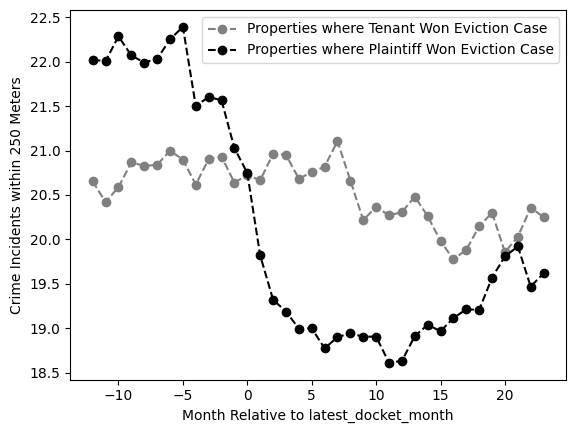

In [21]:
month = []
treatment = []
control = []
for i in range(-12, 24):
    month.append(i)
    control.append(result.params[f'month_{i}'] )
    treatment.append((result.params['judgment_for_plaintiff'] +
                       result.params[f'month_{i}_X_treatment_indicator'] +
                       result.params[f'month_{i}'] ))
fig, ax = plt.subplots()
ax.plot(month,
    control,
    color='grey',
    linestyle='--',
    marker='o',
    label="Properties where Tenant Won Eviction Case")
ax.plot(month,
        treatment,
        color='black',
        linestyle='--',
        marker='o',
        label="Properties where Plaintiff Won Eviction Case")
label = 'latest_docket_month'.replace(" ", "\n")

ax.set_xlabel(f"Month Relative to latest_docket_month")
ax.set_ylabel(f"Crime Incidents within {constants.Analysis.MAIN_RESULTS_RADIUS} Meters")
ax.legend()
plt.show()

In [ ]:
result.f_test("month_6_X_treatment_indicator + judgment_for_plaintiff = 0")

##### 